TODO
- DONE preprocess su immagini di dimensioni reali, e resizing successivo
- migliorare data augmentation in modo che le immagini vengano molto più diverse una dall'altra

# Prepare all the dataset
Before using the following code, install necessary libraries
'pip install pandas opencv-python numpy matplotlib pillow tqdm torch torchvision torchinfo scikit-learn focal-loss-torch'

In [71]:
# =========================================================
# Librerie standard Python
# =========================================================
import os
import gc
import io
import csv
import json
import base64
import shutil
import random
import pathlib
import subprocess
import itertools
from pathlib import Path
from typing import Optional, Dict, Any, List, Callable

# =========================================================
# Librerie scientifiche e di elaborazione dati
# =========================================================
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score
)

# =========================================================
# Librerie per immagini e visualizzazione
# =========================================================
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# =========================================================
# PyTorch e moduli correlati
# =========================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

# =========================================================
# TorchVision
# =========================================================
import torchvision
from torchvision import transforms, models
from torchvision.transforms import functional

# =========================================================
# Altre librerie
# =========================================================
from torchinfo import summary
from focal_loss.focal_loss import FocalLoss

In [72]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [100]:
use_resized = 0
local_runtime = 1
download_data_from_drive = 0
use_data_preprocessing = 1
use_data_augmentation = 1
use_subset_loader = 1
preprocess_out_size = 512

PATIENCE = 5
FINAL_SIZE = (512, 512)
BORDER_COLOR = (0, 0, 0)  # BGR nero


In [74]:
img_size = 224
batch_size = 64

# Target per classe della data augmentation: se None, usa la massima numerosità corrente, altrimenti
# genera un numero di immagini pari al numero scelto (1000) - quante ce ne sono già
TARGET_PER_CLASS = 1000

In [83]:
if use_resized == 1:
  resized_path = 'resized_512/'
else:
  resized_path = ""
drive_zip_path = "/content/drive/MyDrive/COMPUTER VISION PROJECT/dataset/resized_512/"

if local_runtime==1:
    base_path = "/Users/ire/Documents/2° Year/SELECTED TOPICS /project/dataset/"
    #base_path = 'C:/Users/s.simonitti/Desktop/SelectedTopicsInML/dataset/'
else:
    base_path = '/content/drive/MyDrive/Colab Notebooks/dataset/'

data_dir = base_path + resized_path + 'train_images'
val_dir = base_path + resized_path + 'val_images'
test_dir = base_path + resized_path + 'test_images'
processed_train_dir = base_path + "processed_dataset/train_images"
processed_val_dir = base_path + "processed_dataset/val_images"
processed_test_dir = base_path + "processed_dataset/test_images"

processed_train_dir2 = base_path + "processed_dataset2/train_images"
processed_val_dir2 = base_path + "processed_dataset2/val_images"
processed_test_dir2 = base_path + "processed_dataset2/test_images"


if use_data_augmentation==1:
  augm_path="augmented_dataset/"
else:
  augm_path=""

augm_train_dir = base_path + augm_path + "train_images"

In [84]:
if local_runtime==0:
    drive.mount("/content/drive")

## Download zip dataset from drive and unzip it

In [86]:
import os, shutil, pathlib, subprocess

def prepare_dataset_zip(
    drive_zip_path: str,
    local_zip_path: str,
    extract_dir: str,
    ready_flag: str = ".ready",
    verbose: bool = True,
    delete_zip_after_extract: bool = True,
):
    """
    Copia uno zip da Google Drive, lo estrae localmente in /content,
    e cancella lo zip dopo l'estrazione. Usa un file sentinella (.ready)
    per evitare di ripetere l'estrazione se già completata.

    Args:
        drive_zip_path (str): percorso completo allo zip su Drive.
        local_zip_path (str): percorso temporaneo per lo zip locale.
        extract_dir (str): cartella dove estrarre i file.
        ready_flag (str): nome del file sentinella per la cache.
        verbose (bool): stampa messaggi di stato se True.
        delete_zip_after_extract (bool): se True, rimuove lo zip dopo l'estrazione.

    Returns:
        str: percorso della cartella estratta (extract_dir)
    """
    extract_dir = os.path.abspath(extract_dir)
    ready_file = os.path.join(extract_dir, ready_flag)
    pathlib.Path(extract_dir).mkdir(parents=True, exist_ok=True)

    if not os.path.exists(ready_file):
        if verbose: print("Copio lo zip da Drive a /content...")
        shutil.copy(drive_zip_path, local_zip_path)

        if verbose: print("Estrazione in corso...")
        subprocess.run(["unzip", "-q", "-n", local_zip_path, "-d", extract_dir], check=True)

        # crea file sentinella
        open(ready_file, "w").close()
        if verbose: print(f"Dataset pronto in {extract_dir}")

        # rimuove zip locale per liberare spazio
        if delete_zip_after_extract and os.path.exists(local_zip_path):
            os.remove(local_zip_path)
            if verbose: print(f"File zip locale rimosso: {local_zip_path}")
    else:
        if verbose: print(f"Dataset già estratto in {extract_dir}, uso cache locale.")

    return extract_dir

In [87]:
if download_data_from_drive:
    data_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "train_images.zip",
        local_zip_path=base_path + "train_images.zip",
        extract_dir=data_dir
    )
    val_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "val_images.zip",
        local_zip_path=base_path + "val_images.zip",
        extract_dir=val_dir
    )
    test_dir = prepare_dataset_zip(
        drive_zip_path=drive_zip_path + "test_images.zip",
        local_zip_path=base_path + "test_images.zip",
        extract_dir=test_dir
    )

In [88]:

train_images = os.listdir(data_dir)
val_images = os.listdir(val_dir)
test_images = os.listdir(test_dir)

In [89]:
img = cv2.imread(os.path.join(data_dir, train_images[700]))
if img is not None:
    # Argomento 1: Nome della finestra (stringa) | Argomento 2: Immagine (matrice)
    cv2.imshow("Immagine Retina", img) 
    
    # Aspetta che venga premuto un tasto (il valore 0 significa per sempre, fino a una pressione)
    #cv2.waitKey(0) 
    
    # Chiude tutte le finestre di visualizzazione di OpenCV
    cv2.destroyAllWindows() 
else:
    print("Errore nel caricamento dell'immagine. Controlla il percorso o il file.")

In [81]:
print(img.shape)

(512, 512, 3)


## Preprocess images
Denoise and other

In [90]:
def preprocess_retina_image(image_path):
    # 1. Load image (RGB)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. Cropping eye region (remove black background)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find largest contour (eye region)
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    cropped_img = img_rgb[y:y+h, x:x+w]

    # 3. Denoising (Gaussian Blur, kernel size 3x3)
    denoised_img = cv2.GaussianBlur(cropped_img, (3, 3), 0)

    # 4. Histogram Equalization on Y channel (YUV color space)
    img_yuv = cv2.cvtColor(denoised_img, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    he_img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    final_img = cv2.resize(he_img, (preprocess_out_size, preprocess_out_size))

    return final_img

# Preprocess image 2

In [91]:
def crop_fundus_black_border(img_bgr):
    # Work with borders and threshold is easier within a single channel 
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # Determine where to cut
    _, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img_bgr
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    # Apply the cut on the original img
    return img_bgr[y:y+h, x:x+w]

def pad_to_square(img_bgr):
    h, w = img_bgr.shape[:2]
    if h == w:
        return img_bgr
    d = max(h, w)
    top = (d - h) // 2
    bottom = d - h - top
    left = (d - w) // 2
    right = d - w - left
    return cv2.copyMakeBorder(img_bgr, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=BORDER_COLOR)

def clahe_lab(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge([l, a, b])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

def unsharp(img_bgr, k=4, sigma=10):
    blur = cv2.GaussianBlur(img_bgr, (0, 0), sigma)
    sharp = cv2.addWeighted(img_bgr, 1 + k, blur, -k, 0)
    return sharp

def preprocess(img_bgr):
    img = crop_fundus_black_border(img_bgr)
    img = pad_to_square(img)
    img = clahe_lab(img)
    img = unsharp(img, k=1.5, sigma=10)
    img = cv2.resize(img, FINAL_SIZE, interpolation=cv2.INTER_AREA)
    return img

In [92]:
def process_image_batch(
    images_to_process,
    images_dir,
    out_images_dir
):
    for img_name in tqdm(images_to_process, desc="Processing Images", unit="image"):
        # 1. Determina immediatamente il percorso di salvataggio
        save_path = os.path.join(out_images_dir, img_name)

        # 2. CONTROLLO DI ESISTENZA
        if os.path.exists(save_path):
            # Se il file esiste, stampa un messaggio e passa all'immagine successiva
            # print(f"Skipping {img_name}: already processed.")
            continue # Passa all'elemento successivo nel ciclo
    
        # Se il file NON esiste, esegui il processo
        img_path = os.path.join(images_dir, img_name)
    
        try:
            # Elaborazione (viene eseguita solo se il file non esiste)
            processed_img = preprocess_retina_image(img_path)
        
            # Salvataggio
            cv2.imwrite(save_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        
        except Exception as e:
            print(f"Error processing image {img_name}: {e}")

    print(f"Finished processing and saving images to {out_images_dir}")

In [ ]:
if use_data_preprocessing:
    os.makedirs(processed_train_dir, exist_ok=True)
    os.makedirs(processed_val_dir, exist_ok=True)
    os.makedirs(processed_test_dir, exist_ok=True)

    print("Processing training images...")
    process_image_batch(
        images_to_process = train_images,
        images_dir = data_dir,
        out_images_dir = processed_train_dir)

    print("Processing validation images...")
    process_image_batch(
        images_to_process = val_images,
        images_dir = val_dir,
        out_images_dir = processed_val_dir)

    print("Processing testing images...")
    process_image_batch(
        images_to_process = test_images,
        images_dir = test_dir,
        out_images_dir = processed_test_dir)
else:
    processed_train_dir = data_dir
    processed_val_dir = val_dir
    processed_test_dir = test_dir

# 2

In [93]:
if use_data_preprocessing:
    os.makedirs(processed_train_dir2, exist_ok=True)
    os.makedirs(processed_val_dir2, exist_ok=True)
    os.makedirs(processed_test_dir2, exist_ok=True)

    print("Processing training images...")
    process_image_batch(
        images_to_process = train_images,
        images_dir = data_dir,
        out_images_dir = processed_train_dir2)

    print("Processing validation images...")
    process_image_batch(
        images_to_process = val_images,
        images_dir = val_dir,
        out_images_dir = processed_val_dir2)

    print("Processing testing images...")
    process_image_batch(
        images_to_process = test_images,
        images_dir = test_dir,
        out_images_dir = processed_test_dir2)
else:
    processed_train_dir2 = data_dir
    processed_val_dir2 = val_dir
    processed_test_dir2 = test_dir

Processing training images...


Processing Images: 100%|██████████| 2931/2931 [00:29<00:00, 98.61image/s] 


Finished processing and saving images to /Users/ire/Documents/2° Year/SELECTED TOPICS /project/dataset/processed_dataset2/train_images
Processing validation images...


Processing Images: 100%|██████████| 366/366 [00:03<00:00, 99.00image/s] 


Finished processing and saving images to /Users/ire/Documents/2° Year/SELECTED TOPICS /project/dataset/processed_dataset2/val_images
Processing testing images...


Processing Images: 100%|██████████| 366/366 [00:03<00:00, 99.15image/s] 

Finished processing and saving images to /Users/ire/Documents/2° Year/SELECTED TOPICS /project/dataset/processed_dataset2/test_images


## Data Augmentation

In [97]:
# Percorsi
# TRAIN_IMG_DIR = Path(processed_train_dir)
TRAIN_IMG_DIR = Path(processed_train_dir2)

TRAIN_CSV_IN  = Path(base_path + "train.csv.xls")
TRAIN_CSV_OUT = Path(base_path + augm_path + "train.csv.xls")
# Dove salvare i nuovi file
OUT_IMG_DIR = Path(augm_train_dir)

In [ ]:
class FundusAugment:
    """
    Augmentations secondo Tabella 3:
    - Zoom range: 0.2  -> scale (0.8, 1.0)
    - Rotation range: ±10°
    - Flip: orizzontale + verticale
    - Brightness/Color(=Saturation)/Contrast: (0.5, 1.5)
    """
    def __init__(
        self,
        img_size: 512,
        p_zoom: float = 0.7,
        p_hflip: float = 0.5,
        p_vflip: float = 0.5,
        p_rotate: float = 1,
        p_color: float = 1,
        zoom_scale=(0.80, 1.00),
        zoom_ratio=(0.95, 1.05),
        rot_deg: float = 20.0,
        brightness=(0.5, 1.5),
        contrast=(0.5, 1.5),
        color_adjustment=(0.5, 1.5)
    ):
        self.img_size = img_size
        self.p_zoom = p_zoom
        self.p_hflip = p_hflip
        self.p_vflip = p_vflip
        self.p_rotate = p_rotate
        self.p_color = p_color
        self.zoom_scale = zoom_scale
        self.zoom_ratio = zoom_ratio
        self.rot_deg = rot_deg
        self.resize = transforms.Resize((img_size, img_size))

        self.color_jitter = transforms.ColorJitter(
            brightness=brightness,
            contrast=contrast,
            saturation=color_adjustment,
            hue=0.0
        )

    def __call__(self, img: Image.Image) -> Image.Image:
        img = self.resize(img)

        if random.random() < self.p_zoom:
            rrc = transforms.RandomResizedCrop(
                self.img_size, scale=self.zoom_scale#, ratio=self.zoom_ratio
            )
            img = rrc(img)

        if random.random() < self.p_hflip:
            img = functional.hflip(img)
        if random.random() < self.p_vflip:
            img = functional.vflip(img)

        if random.random() < self.p_rotate:
            angle = random.uniform(-self.rot_deg, self.rot_deg)
            img = functional.rotate(img, angle, interpolation=Image.BICUBIC, expand=False, fill=0)

        if random.random() < self.p_color:
            img = self.color_jitter(img)

        return img
  
# -----------------------------
# UTILS
# -----------------------------
EXTS = [".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".webp"]

def find_image_for_id(id_code: str, root: Path) -> Path | None:
    for ext in EXTS:
        p = root / f"{id_code}{ext}"
        if p.exists():
            return p
    # fallback: cerca per pattern (es. file con id_code come prefisso)
    matches = list(root.glob(f"{id_code}.*"))
    return matches[0] if matches else None

def load_df(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    cols = [c.lower() for c in df.columns]
    # normalizza nomi colonne attese
    if "id_code" in cols and "diagnosis" in cols:
        return df.rename(columns={df.columns[cols.index("id_code")]: "id_code",
                                  df.columns[cols.index("diagnosis")]: "diagnosis"})
    elif "filepath" in cols and "diagnosis" in cols:
        return df.rename(columns={df.columns[cols.index("filepath")]: "filepath",
                                  df.columns[cols.index("diagnosis")]: "diagnosis"})
    else:
        raise ValueError("CSV deve avere colonne (id_code,diagnosis) oppure (filepath,diagnosis).")

def row_to_path(row) -> Path:
    if "filepath" in row and isinstance(row["filepath"], str):
        return Path(row["filepath"])
    # se abbiamo id_code, cerchiamo il file nella cartella root
    return find_image_for_id(str(row["id_code"]), TRAIN_IMG_DIR)


In [ ]:
if use_data_augmentation==1:
  # -----------------------------
  # CONFIG
  # -----------------------------
  SEED = 42
  random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

  # Modalità CSV out: "w" per riscrivere tutto (originali + augment), "a" per appendere solo le nuove righe
  CSV_MODE = "w"
  WRITE_HEADER = True if CSV_MODE == "w" else False
  
  # Se la cartella di output contiene già immagini aumentate, salta tutto
  if OUT_IMG_DIR.exists() and any(OUT_IMG_DIR.glob("*.png")):
      print(f"Data augmentation già eseguita: trovate immagini in {OUT_IMG_DIR}.")
      print("Salto la rigenerazione e uso i file esistenti.")
  else:
    OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)
    # Colonna per l'output: "id_code" (consigliato se il tuo Dataset fa f"{id_code}.jpg") oppure "filepath"
    OUTPUT_USES_ID_CODE = True

    augment = FundusAugment(img_size=preprocess_out_size)

    # -----------------------------
    # CARICA CSV E CONTA PER CLASSE
    # -----------------------------
    df_in = load_df(TRAIN_CSV_IN)
    df_in["diagnosis"] = df_in["diagnosis"].astype(int)

    # calcola counts per classe dal CSV
    counts = df_in.groupby("diagnosis").size().to_dict()
    all_classes = sorted(df_in["diagnosis"].unique().tolist())
    if TARGET_PER_CLASS is None:
      TARGET_PER_CLASS = max(counts.values())

    print("Conteggi iniziali:", counts)
    print("Target per classe:", TARGET_PER_CLASS)

    # mappa: classe -> lista (id_code, path)
    by_class = {c: [] for c in all_classes}
    for _, row in df_in.iterrows():
      p = row_to_path(row)
      if p is None or not p.exists():
        # salta righe orfane
        continue
      if "id_code" in df_in.columns:
        by_class[row["diagnosis"]].append((str(row["id_code"]), p))
      else:
        # crea un id_code dal filename (senza estensione)
        by_class[row["diagnosis"]].append((p.stem, p))

    # contatori per generare suffissi univoci per ciascun id_code base
    per_id_counters = {}

    # -----------------------------
    # PREPARA CSV DI OUTPUT
    # -----------------------------
    TRAIN_CSV_OUT.parent.mkdir(parents=True, exist_ok=True)
    mode = CSV_MODE
    write_header = WRITE_HEADER
    fout = open(TRAIN_CSV_OUT, mode, newline="", encoding="utf-8")
    writer = csv.writer(fout)

    # Decidi intestazioni e funzione che scrive una riga
    if OUTPUT_USES_ID_CODE:
      if write_header:
        writer.writerow(["id_code", "diagnosis"])
      def write_row_id(id_code: str, diagnosis: int):
        writer.writerow([id_code, diagnosis])
    else:
      if write_header:
        writer.writerow(["filepath", "diagnosis"])
      def write_row_path(path: Path, diagnosis: int):
        writer.writerow([str(path), diagnosis])

  # se stai riscrivendo tutto, copia anche le righe originali nel nuovo CSV
    if mode == "w":
      for c in all_classes:
          for id_code, path in by_class[c]:
            if OUTPUT_USES_ID_CODE:
                write_row_id(id_code, c)
            else:
                write_row_path(path, c)

  # -----------------------------
  # GENERA AUGMENT PER RAGGIUNGERE IL TARGET
  # -----------------------------
    for c in all_classes:
      current = len(by_class[c])
      need = max(0, TARGET_PER_CLASS - current)
      if need == 0:
        continue

      print(f"Classe {c}: genero {need} immagini…")
      src_items = by_class[c]
      if not src_items:
        continue

      for i in tqdm(range(need), desc=f"Augment class {c}"):
        base_id, src_path = random.choice(src_items)
        with Image.open(src_path) as im:
            im = im.convert("RGB")
            aug_img = augment(im)

        # genera nome univoco
        k = per_id_counters.get(base_id, 0)
        per_id_counters[base_id] = k + 1
        new_id = f"{base_id}aug{k:05d}"
        out_path = OUT_IMG_DIR / f"{new_id}.png"

        # evita collisioni nel raro caso il file esista
        while out_path.exists():
            k += 1
            per_id_counters[base_id] = k + 1
            new_id = f"{base_id}aug{k:05d}"
            out_path = OUT_IMG_DIR / f"{new_id}.png"

        aug_img.save(out_path, format="PNG", quality=92, optimize=True, progressive=True)

        # scrivi riga CSV per la nuova immagine
        if OUTPUT_USES_ID_CODE:
            write_row_id(new_id, c)
        else:
            write_row_path(out_path, c)

    src = Path(processed_train_dir)
    dst = Path(augm_train_dir)

    # Copia tutto il contenuto (anche sottocartelle e file)
    shutil.copytree(src, dst, dirs_exist_ok=True)
    fout.close()
    print(f"Immagini nuove in: {OUT_IMG_DIR}")
    print(f"CSV scritto in: {TRAIN_CSV_OUT}")
else:
  augm_train_dir = processed_train_dir

# Data Augmentation 2

In [101]:
def random_hflip(img):
    return cv2.flip(img, 1) if random.random() < 0.5 else img  # horizontal only

def random_rotate(img, max_deg=15):
    h, w = img.shape[:2]
    angle = np.random.uniform(-max_deg, max_deg)
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=BORDER_COLOR)

def random_zoom(img, max_zoom=0.2):
    h, w = img.shape[:2]
    s = 1.0 + np.random.uniform(-max_zoom, max_zoom)
    nh, nw = int(h*s), int(w*s)
    z = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
    if s >= 1.0:
        y0 = (nh - h)//2; x0 = (nw - w)//2
        return z[y0:y0+h, x0:x0+w]
    # zooming out: place on black background, not reflected
    canvas = np.zeros_like(img, dtype=np.uint8)
    y0 = (h - nh)//2; x0 = (w - nw)//2
    canvas[y0:y0+nh, x0:x0+nw] = z
    return canvas

    # zooming out: place on reflected canvas to avoid black borders
    canvas = cv2.copyMakeBorder(img, 0, 0, 0, 0, borderType=cv2.BORDER_REFLECT_101)
    y0 = (h - nh) // 2
    x0 = (w - nw) // 2
    canvas[y0:y0 + nh, x0:x0 + nw] = z
    return canvas

def jitter_brightness(img, low=0.8, high=1.2):
    factor = np.random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 2] = np.clip(hsv[:, :, 2] * factor, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

def jitter_contrast(img, low=0.85, high=1.15):
    factor = np.random.uniform(low, high)
    img_f = img.astype(np.float32)
    mean = np.mean(img_f, axis=(0, 1), keepdims=True)
    out = np.clip((img_f - mean) * factor + mean, 0, 255)
    return out.astype(np.uint8)

def jitter_saturation(img, low=0.8, high=1.2):
    factor = np.random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * factor, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)

def jitter_gamma(img, low=0.9, high=1.1):
    gamma = np.random.uniform(low, high)
    inv = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)

def augment_once(img):
    out = img.copy()
    out = random_hflip(out)
    out = random_rotate(out, 15)
    out = random_zoom(out, 0.2)
    if random.random() < 0.9: out = jitter_brightness(out, 0.9, 1.1)
    if random.random() < 0.9: out = jitter_contrast(out, 0.9, 1.1)
    if random.random() < 0.9: out = jitter_saturation(out, 0.9, 1.1)
    if random.random() < 0.5: out = jitter_gamma(out, 0.95, 1.05)

    return out


In [103]:
EXTS = [".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".webp"]

def find_image_for_id(id_code: str, root: Path) -> Path | None:
    for ext in EXTS:
        p = root / f"{id_code}{ext}"
        if p.exists():
            return p
    # fallback: cerca per pattern (es. file con id_code come prefisso)
    matches = list(root.glob(f"{id_code}.*"))
    return matches[0] if matches else None

def load_df(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    cols = [c.lower() for c in df.columns]
    # normalizza nomi colonne attese
    if "id_code" in cols and "diagnosis" in cols:
        return df.rename(columns={df.columns[cols.index("id_code")]: "id_code",
                                  df.columns[cols.index("diagnosis")]: "diagnosis"})
    elif "filepath" in cols and "diagnosis" in cols:
        return df.rename(columns={df.columns[cols.index("filepath")]: "filepath",
                                  df.columns[cols.index("diagnosis")]: "diagnosis"})
    else:
        raise ValueError("CSV deve avere colonne (id_code,diagnosis) oppure (filepath,diagnosis).")

def row_to_path(row) -> Path:
    if "filepath" in row and isinstance(row["filepath"], str):
        return Path(row["filepath"])
    # se abbiamo id_code, cerchiamo il file nella cartella root
    return find_image_for_id(str(row["id_code"]), TRAIN_IMG_DIR)

# Necessario per random_rotate (borderValue) e per eventuali canvas

if use_data_augmentation == 1:
    # -----------------------------
    # CONFIG
    # -----------------------------
    SEED = 42
    random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

    # Modalità CSV out: "w" per riscrivere tutto (originali + augment), "a" per appendere solo le nuove righe
    CSV_MODE = "w"
    WRITE_HEADER = True if CSV_MODE == "w" else False

    # Se la cartella di output contiene già immagini aumentate, salta tutto
    if OUT_IMG_DIR.exists() and any(OUT_IMG_DIR.glob("*.png")):
        print(f"Data augmentation già eseguita: trovate immagini in {OUT_IMG_DIR}.")
        print("Salto la rigenerazione e uso i file esistenti.")
    else:
        OUT_IMG_DIR.mkdir(parents=True, exist_ok=True)

        # Colonna per l'output: "id_code" (consigliato se il tuo Dataset fa f"{id_code}.jpg") oppure "filepath"
        OUTPUT_USES_ID_CODE = True

        # -----------------------------
        # CARICA CSV E CONTA PER CLASSE
        # -----------------------------
        df_in = load_df(TRAIN_CSV_IN)
        df_in["diagnosis"] = df_in["diagnosis"].astype(int)

        counts = df_in.groupby("diagnosis").size().to_dict()
        all_classes = sorted(df_in["diagnosis"].unique().tolist())
        if TARGET_PER_CLASS is None:
            TARGET_PER_CLASS = max(counts.values())

        print("Conteggi iniziali:", counts)
        print("Target per classe:", TARGET_PER_CLASS)

        # mappa: classe -> lista (id_code, path)
        by_class = {c: [] for c in all_classes}
        for _, row in df_in.iterrows():
            p = row_to_path(row)
            if p is None or not p.exists():
                continue
            if "id_code" in df_in.columns:
                by_class[row["diagnosis"]].append((str(row["id_code"]), p))
            else:
                by_class[row["diagnosis"]].append((p.stem, p))

        # contatori per generare suffissi univoci per ciascun id_code base
        per_id_counters = {}

        # -----------------------------
        # PREPARA CSV DI OUTPUT
        # -----------------------------
        TRAIN_CSV_OUT.parent.mkdir(parents=True, exist_ok=True)
        mode = CSV_MODE
        write_header = WRITE_HEADER
        fout = open(TRAIN_CSV_OUT, mode, newline="", encoding="utf-8")
        writer = csv.writer(fout)

        # intestazioni e helpers per scrivere righe
        if OUTPUT_USES_ID_CODE:
            if write_header:
                writer.writerow(["id_code", "diagnosis"])
            def write_row_id(id_code: str, diagnosis: int):
                writer.writerow([id_code, diagnosis])
        else:
            if write_header:
                writer.writerow(["filepath", "diagnosis"])
            def write_row_path(path: Path, diagnosis: int):
                writer.writerow([str(path), diagnosis])

        # se stai riscrivendo tutto, copia anche le righe originali nel nuovo CSV
        if mode == "w":
            for c in all_classes:
                for id_code, path in by_class[c]:
                    if OUTPUT_USES_ID_CODE:
                        write_row_id(id_code, c)
                    else:
                        write_row_path(path, c)

        # -----------------------------
        # GENERA AUGMENT PER RAGGIUNGERE IL TARGET (OpenCV/BGR)
        # -----------------------------
        for c in all_classes:
            current = len(by_class[c])
            need = max(0, TARGET_PER_CLASS - current)
            if need == 0:
                continue

            print(f"Classe {c}: genero {need} immagini…")
            src_items = by_class[c]
            if not src_items:
                continue

            for _ in tqdm(range(need), desc=f"Augment class {c}"):
                base_id, src_path = random.choice(src_items)

                # Leggi in BGR (OpenCV)
                bgr = cv2.imread(str(src_path), cv2.IMREAD_COLOR)
                if bgr is None:
                    # immagine illeggibile -> salta
                    continue

                # Applica la tua augmentation OpenCV
                aug_bgr = augment_once(bgr)

                # Genera nome univoco
                k = per_id_counters.get(base_id, 0)
                per_id_counters[base_id] = k + 1
                new_id = f"{base_id}aug{k:05d}"
                out_path = OUT_IMG_DIR / f"{new_id}.png"

                # evita collisioni nel raro caso il file esista
                while out_path.exists():
                    k += 1
                    per_id_counters[base_id] = k + 1
                    new_id = f"{base_id}aug{k:05d}"
                    out_path = OUT_IMG_DIR / f"{new_id}.png"

                # Salva in PNG (BGR va bene con cv2.imwrite)
                ok = cv2.imwrite(str(out_path), aug_bgr)
                if not ok:
                    # se fallisce la scrittura, salta la riga CSV
                    continue

                # scrivi riga CSV per la nuova immagine
                if OUTPUT_USES_ID_CODE:
                    write_row_id(new_id, c)
                else:
                    write_row_path(out_path, c)

        # Copia tutto il contenuto (anche sottocartelle e file)
        src = Path(processed_train_dir)
        dst = Path(augm_train_dir)
        shutil.copytree(src, dst, dirs_exist_ok=True)
        fout.close()
        print(f"Immagini nuove in: {OUT_IMG_DIR}")
        print(f"CSV scritto in: {TRAIN_CSV_OUT}")
else:
    augm_train_dir = processed_train_dir


Conteggi iniziali: {0: 1434, 1: 300, 2: 808, 3: 154, 4: 234}
Target per classe: 1000
Classe 1: genero 700 immagini…


Augment class 1: 100%|██████████| 700/700 [00:11<00:00, 62.31it/s]


Classe 2: genero 192 immagini…


Augment class 2: 100%|██████████| 192/192 [00:03<00:00, 62.17it/s]


Classe 3: genero 846 immagini…


Augment class 3: 100%|██████████| 846/846 [00:13<00:00, 64.23it/s]


Classe 4: genero 766 immagini…


Augment class 4: 100%|██████████| 766/766 [00:11<00:00, 64.34it/s]


Immagini nuove in: /Users/ire/Documents/2° Year/SELECTED TOPICS /project/dataset/augmented_dataset/train_images
CSV scritto in: /Users/ire/Documents/2° Year/SELECTED TOPICS /project/dataset/augmented_dataset/train.csv.xls


## Load image names and labes

In [104]:
labels_train = pd.read_csv(base_path + augm_path + "train.csv.xls")
labels_val = pd.read_csv(base_path + "val.csv.xls")
labels_test = pd.read_csv(base_path + "test.csv.xls")

## Check dataset

In [105]:
# Calcola le percentuali per ciascun set
train_vals_cnt = labels_train['diagnosis'].value_counts().sort_index()
test_vals_cnt  = labels_test['diagnosis'].value_counts().sort_index()
val_vals_cnt   = labels_val['diagnosis'].value_counts().sort_index()

train_vals_perc = labels_train['diagnosis'].value_counts(normalize=True).sort_index() * 100
test_vals_perc  = labels_test['diagnosis'].value_counts(normalize=True).sort_index() * 100
val_vals_perc   = labels_val['diagnosis'].value_counts(normalize=True).sort_index() * 100

In [106]:
# Crea una tabella
table_cnt = pd.DataFrame({
    'TRAIN': train_vals_cnt,
    'TEST': test_vals_cnt,
    'VALIDATION': val_vals_cnt
}).T  # trasponi per avere i dataset come righe

table_perc = pd.DataFrame({
    'TRAIN': round(train_vals_perc, 3),
    'TEST': round(test_vals_perc, 3),
    'VALIDATION': round(val_vals_perc, 3)
}).T  # trasponi per avere i dataset come righe

# Mostra le tabella
print("Dataset count")
print(table_cnt)
print()
print("Dataset percentage")
print(table_perc)


Dataset count
diagnosis      0     1     2     3     4
TRAIN       1434  1000  1000  1000  1000
TEST         199    30    87    17    33
VALIDATION   172    40   104    22    28

Dataset percentage
diagnosis        0       1       2       3       4
TRAIN       26.389  18.403  18.403  18.403  18.403
TEST        54.372   8.197  23.770   4.645   9.016
VALIDATION  46.995  10.929  28.415   6.011   7.650


<Axes: xlabel='diagnosis'>

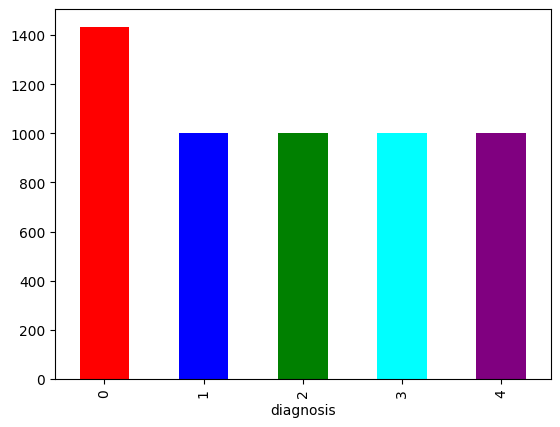

In [107]:
labels_train['diagnosis'].value_counts().plot(kind = 'bar', color = ['red', 'blue', 'green', 'cyan', 'purple'])

## Set up transformation

In [108]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    #transforms.CenterCrop(img_size),
    transforms.ToTensor(),               # convert to tensor [0,1]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],      # ImageNet mean
        std=[0.229, 0.224, 0.225]
    )
])

## Define custom Dataset

In [109]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None, preload=True):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.preload = preload

        # Map filenames and labels
        self.filenames = self.labels_df['id_code'].values
        self.labels = self.labels_df['diagnosis'].values

        self.images = []  # qui salveremo le immagini pre-caricate

        if self.preload:
            print("Caricamento immagini in RAM...")
            for fname in tqdm(self.filenames, desc="Caricamento immagini", unit="img"):
                img_path = os.path.join(self.img_dir, fname + ".png")
                image = Image.open(img_path).convert("RGB")

                if self.transform:
                    image = self.transform(image)

                self.images.append(image)
            print(f"Caricate {len(self.images)} immagini in memoria.")

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if self.preload:
            image = self.images[idx]
        else:
            img_path = os.path.join(self.img_dir, self.filenames[idx] + ".png")
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)

        label = self.labels[idx]

        # If label is not numeric, convert to class index
        if isinstance(label, str):
            # Optional: map string labels to integers
            # You can build a mapping outside this class
            raise ValueError("Labels are strings. Convert them to int first.")

        return image, label


In [110]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda') # Uncomment this to run on GPU
device

device(type='cpu')

In [111]:
num_cuda_devices = torch.cuda.device_count()
print(f"CUDA è disponibile. Numero di dispositivi GPU: {num_cuda_devices}")

# (Opzionale) Stampa il nome di ciascun dispositivo
for i in range(num_cuda_devices):
    print(f"Dispositivo {i}: {torch.cuda.get_device_name(i)}")

CUDA è disponibile. Numero di dispositivi GPU: 0


## Create datasets and loaders

Caricamento dataset sulla RAM (set FALSE se non vuoi)

In [112]:
if local_runtime==1:
    train_set_preload = True
else:
    train_set_preload = False
    
train_set = CustomImageDataset(augm_train_dir, labels_train, transform=transform, preload=train_set_preload)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_set = CustomImageDataset(processed_val_dir, labels_val, transform=transform, preload=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_set = CustomImageDataset(processed_test_dir, labels_test, transform=transform, preload=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Caricamento immagini in RAM...


Caricamento immagini: 100%|██████████| 5434/5434 [00:47<00:00, 114.61img/s]

Caricate 5434 immagini in memoria.


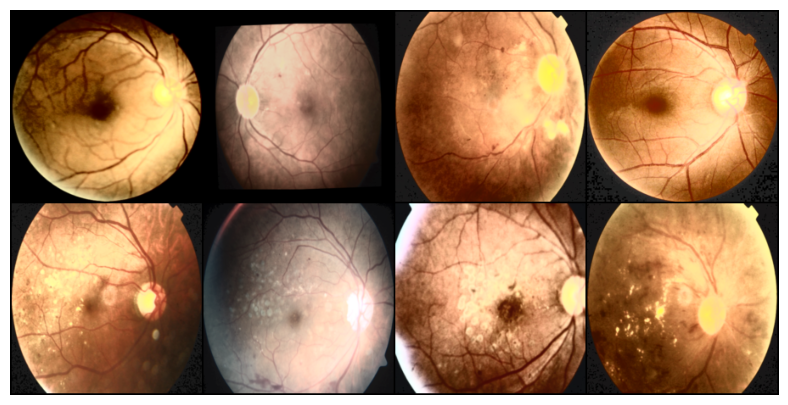

Labels: [0, 2, 2, 0, 2, 4, 1, 3]


In [113]:
# Get one batch from the DataLoader
images, labels = next(iter(train_loader))  # images: [B, 3, 224, 224], labels: [B]

# Denormalize for display (undo ImageNet normalization)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
images = images * std + mean  # undo normalization

# Make a grid of images
grid = torchvision.utils.make_grid(images[:8], nrow=4)  # first 8 images, 4 per row

# Convert to numpy for matplotlib (C,H,W -> H,W,C)
grid_np = grid.permute(1, 2, 0).numpy()

# Plot the images
plt.figure(figsize=(10, 5))
plt.imshow(grid_np)
plt.axis('off')
plt.show()

# Print corresponding labels
print("Labels:", labels[:8].tolist())

## Subset Loader

In samples_per_class decidere quanti samples prendere per avere una distribuzione equa

In [114]:
if use_subset_loader == 1:
    num_classes = 5
    samples_per_class = 700

    # Dictionary to hold indices for each class
    class_indices = {c: [] for c in range(num_classes)}

    # Iterate through dataset and collect indices by class
    for idx, row in labels_train.iterrows():
        label = int(row['diagnosis'])
        class_indices[label].append(idx)

    # For each class, randomly sample 200 indices
    subset_indices = []
    for c in range(num_classes):
        chosen = np.random.choice(class_indices[c], samples_per_class, replace=False)
        subset_indices.extend(chosen)

    # Shuffle the final list of subset indices
    np.random.shuffle(subset_indices)

    # Create a subset of the dataset
    subset_dataset = Subset(train_set, subset_indices)

    # Create a new DataLoader for the subset
    subset_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

In [115]:
from collections import Counter

if use_subset_loader == 1:
    labels_check = []
    for _, label in subset_dataset:
        labels_check.append(int(label))

    print("Class distribution in subset:", Counter(labels_check))

Class distribution in subset: Counter({2: 700, 1: 700, 0: 700, 3: 700, 4: 700})


In [116]:
if use_subset_loader==1:
    loader_selected = subset_loader
else:
    loader_selected = train_loader

## Helper function for model training and evaluation

In [117]:
def build_optimizer(
    name: str,
    params,
    lr: None,
    weight_decay: float = 0.0
) -> optim.Optimizer:
    """
    Crea un optimizer da stringa. Esempi:
    'adam', 'sgd', 'adamw', 'rmsprop', 'adagrad'
    opt_kwargs: qualunque parametro aggiuntivo (es. weight_decay, momentum...)
    """
    name = name.strip().lower()
    if name == "adam":
        if lr is None:
            return optim.Adam(params, weight_decay=weight_decay)
        else:
            return optim.Adam(params, lr=lr, weight_decay=weight_decay)
    if name == "adamw":
        if lr is None:
            return optim.AdamW(params, weight_decay=weight_decay)
        else:
            return optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    if name == "sgd":
        if lr is None:
            return optim.SGD(params, weight_decay=weight_decay)
        else:
            return optim.SGD(params, lr=lr, weight_decay=weight_decay)
    if name == "rmsprop":
        if lr is None:
            return optim.RMSprop(params, weight_decay=weight_decay)
        else:
            return optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
    if name == "adagrad":
        if lr is None:
            return optim.Adagrad(params, weight_decay=weight_decay)
        else:
            return optim.Adagrad(params, lr=lr, weight_decay=weight_decay)
    raise ValueError(f"Optimizer sconosciuto: '{name}'")

def is_focal_loss(
    name: str
) -> nn.Module:
    name = name.strip().lower()
    if name in ("focal", "focallos"):
        return True
    else:
        return False

def build_criterion(
    name: str
) -> nn.Module:
    """
    Crea una loss da stringa. Esempi:
    'crossentropy', 'bcelogits', 'mse', 'nll', 'smoothl1'
    loss_kwargs: parametri extra (es. weight, reduction, label_smoothing...)
    """
    name = name.strip().lower()
    if name in ("crossentropy", "crossentropyloss", "ce"):
        return nn.CrossEntropyLoss()
    if name in ("bcelogits", "bcelosslogits", "bcelogitsloss"):
        return nn.BCEWithLogitsLoss()
    if name in ("mse", "mseloss", "l2"):
        return nn.MSELoss()
    if name in ("nll", "nllloss"):
        return nn.NLLLoss()
    if name in ("smoothl1", "huber"):
        return nn.SmoothL1Loss()
    if is_focal_loss(name):
        return FocalLoss(gamma=2.0)
    raise ValueError(f"Criterion sconosciuto: '{name}'")

def build_scheduler(name: str, optimizer, num_epochs) -> nn.Module:
    name = name.strip().lower()
    if name in ("reducelronplateau"):
        return ReduceLROnPlateau(
            optimizer,
            mode='min',       # because we want to minimize val_loss
            factor=0.3,       # reduce LR by 0.3
            patience=2,       # wait 2 epochs before reducing LR
        )
    elif name in ("cosineannealing"):
        return CosineAnnealingLR(
            optimizer, 
            T_max=num_epochs
        )
    else:
        return None

In [118]:
def multiclass_accuracy(outputs: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Calcola l'accuracy per classificazione multi-classe (es. 5 classi).
    outputs: tensor [N, num_classes]
    targets: tensor [N]
    """
    preds = outputs.argmax(dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct / max(1, total)

In [119]:
def train_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    val_loader: None,
    optimizer_name: "adam",
    criterion_name: "crossentropy",
    lr: None,
    num_epochs: 5,
    device: None,
    scheduler_name = "",
    verbose: bool = True,
    model_output_softmax = False,
    weight_decay: float = 0.0
) -> Dict[str, List[float]]:
    """
    Esegue training (e opzionalmente validazione) per num_epochs.
    Ritorna uno storico con 'step_losses', 'epoch_losses', 'val_losses'.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = build_criterion(criterion_name)
    optimizer = build_optimizer(optimizer_name, model.parameters(), lr=lr, weight_decay=weight_decay)
    uses_focal_loss = is_focal_loss(criterion_name)
    scheduler = build_scheduler(scheduler_name, optimizer, num_epochs)

    history = {
        "step_losses": [],
        "epoch_losses": [],
        "val_losses": [],
        "epoch_acc": [],
        "val_acc": []
    }

    best_val = -1.0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs}")
            train_iter = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        else:
            train_iter = enumerate(train_loader)

        for _, (images, labels) in train_iter:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            if uses_focal_loss and not model_output_softmax:
                loss = criterion(torch.softmax(outputs, dim=-1), labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # --- metriche ---
            acc = multiclass_accuracy(outputs, labels)
            correct_train += acc * labels.size(0)
            total_train += labels.size(0)

            epoch_loss += loss.item()
            history["step_losses"].append(loss.item())

            if verbose:
                if hasattr(train_iter, "set_description"):
                    train_iter.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
                if hasattr(train_iter, "set_postfix"):
                    train_iter.set_postfix(loss=loss.item(), acc=acc)

        avg_epoch_loss = epoch_loss / max(1, len(train_loader))
        epoch_acc = correct_train / max(1, total_train)
        history["epoch_losses"].append(avg_epoch_loss)
        history["epoch_acc"].append(epoch_acc)

        # Validazione (se fornito val_loader)
        if val_loader is not None:
            model.eval()
            val_loss_total = 0.0
            correct_val = 0
            total_val = 0
            n_val_batches = 0
            with torch.no_grad():
                val_iter = tqdm(val_loader, total=len(val_loader), leave=False) if verbose else val_loader
                for X_val, Y_val in val_iter:
                    X_val, Y_val = X_val.to(device), Y_val.to(device)
                    Y_pred_val = model(X_val)

                    if uses_focal_loss:
                        loss_val = criterion(torch.softmax(Y_pred_val, dim=-1), Y_val)
                    else:
                        loss_val = criterion(Y_pred_val, Y_val)

                    val_loss_total += loss_val.item()
                    acc_val = multiclass_accuracy(Y_pred_val, Y_val)
                    correct_val += acc_val * Y_val.size(0)
                    total_val += Y_val.size(0)

                    n_val_batches += 1

            avg_val_loss = val_loss_total / max(1, n_val_batches)
            val_acc = correct_val / max(1, total_val)
            history["val_losses"].append(avg_val_loss)
            history["val_acc"].append(val_acc)
            if verbose:
                print(f"Epoch {epoch+1} training loss: {avg_epoch_loss:.4f} train acc={epoch_acc:.4f}, validation loss: {avg_val_loss:.4f} validation acc={val_acc:.4f}")
        else:
            # se non c'è validazione, manteniamo lunghezze allineate
            history["val_losses"].append(float('nan'))
            history["val_acc"].append(float('nan'))
            if verbose:
                print(f"Epoch {epoch+1} training loss: {avg_epoch_loss:.4f} train acc={epoch_acc:.4f}")

        # Step dello scheduler (se presente)
        if scheduler is not None:
            # Alcuni scheduler richiedono val_loss (es. ReduceLROnPlateau)
            if hasattr(scheduler, 'step') and scheduler.__class__.__name__.lower().startswith('reducelronplateau'):
                last_val = history["val_losses"][-1]
                # usa train loss se non c'è validazione
                metric = last_val if not (last_val != last_val) else avg_epoch_loss
                scheduler.step(metric)
            else:
                scheduler.step()

        # early stopping on val_acc
        if val_acc > best_val:
            best_val = val_acc
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= PATIENCE:
                print("Early stopping.")
                break

    return history, model


In [120]:
def plot_history(history, figsize=(15, 5), save_path=None, show=True):
    """
    Mostra (e opzionalmente salva) tre grafici:
      1. Step Losses (per batch)
      2. Epoch Losses (train e validation)
      3. Epoch Accuracy (train e validation)

    Parametri
    ----------
    history : dict
        Dizionario prodotto da train_model, con chiavi:
            - "step_losses": perdite per batch
            - "epoch_losses": perdite medie di training per epoca
            - "val_losses": perdite medie di validazione per epoca
            - "epoch_acc": accuracy di training per epoca
            - "val_acc": accuracy di validazione per epoca
    figsize : tuple
        Dimensioni della figura (default: (15, 4))
    save_path : str, opzionale
        Se specificato, salva il grafico nel percorso indicato.
    show : bool
        Se True mostra il grafico (default: True)
    title : str
        Titolo generale della figura.
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # --- Step losses (batch) ---
    axes[0].plot(history["step_losses"])
    axes[0].set_title("Step Losses")
    axes[0].set_xlabel("Step")
    axes[0].set_ylabel("Loss")

    # --- Epoch losses (train + val) ---
    axes[1].plot(history["epoch_losses"], label="Training Loss")
    axes[1].plot(history["val_losses"], label="Validation Loss")
    axes[1].set_title("Epoch Losses")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()

    axes[2].plot(history.get("epoch_acc", []), label="Training Accuracy", marker='o')
    axes[2].plot(history.get("val_acc", []), label="Validation Accuracy", marker='o')
    axes[2].set_title("Epoch Accuracy")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Accuracy")
    axes[2].set_ylim(0, 1)
    axes[2].legend()
    #axes[2].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    if show:
        plt.show()

    return fig, axes


In [121]:
def evaluate_model(
    model,
    test_loader,
    average: str = "macro",
    show_confusion: bool = False
):
    """
    Valuta il modello sul test set e restituisce le metriche principali.

    Parametri
    ----------
    model : torch.nn.Module
        Il modello PyTorch da valutare.
    test_loader : DataLoader
        Dataloader del set di test.
    average : str
        Tipo di media per precision/recall/F1 ("macro", "micro", "weighted", "binary").
    show_confusion : bool
        Se True, stampa anche la matrice di confusione.

    Ritorna
    -------
    metrics : dict
        Dizionario con chiavi:
        - "accuracy"
        - "precision"
        - "recall"
        - "f1"
        - "confusion_matrix" (se show_confusion=True)
    """
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Calcolo metriche ---
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average=average, zero_division=0)
    rec = recall_score(all_labels, all_preds, average=average, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=average, zero_division=0)

    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }

    cm = confusion_matrix(all_labels, all_preds)
    if show_confusion:
        metrics["confusion_matrix"] = cm
        print("\nConfusion Matrix:\n", cm)

    print(f"Test Accuracy: {acc * 100:.2f}% | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f}")

    return metrics, cm


In [122]:
def cleanup_torch_env(model_name: None):
    """
    Pulisce in sicurezza l'ambiente PyTorch:
    - Sposta il modello su CPU (se esiste)
    - Elimina l'optimizer (se esiste)
    - Elimina eventuali variabili temporanee note
    - Esegue garbage collection e svuota la cache GPU

    Parametri
    ----------
    model_name : str
        Nome della variabile modello da spostare su CPU.
    optimizer_name : str
        Nome della variabile optimizer da eliminare.
    """
    # --- Sposta modello su CPU ---
    if model_name in globals():
        globals()[model_name] = globals()[model_name].cpu()
    elif model_name in locals():
        locals()[model_name] = locals()[model_name].cpu()

    # --- Cancella variabili temporanee ---
    temp_vars = [
        'outputs', 'loss', 'images', 'labels',
        'Y_pred_val', 'X_val', 'Y_val',
        'sample_preds_labels', 'sample_labels',
        'sample_images', 'sample_preds',
        'all_labels', 'all_preds'
    ]

    for var in temp_vars:
        if var in globals():
            del globals()[var]
        elif var in locals():
            del locals()[var]

    # --- Garbage collector e cache GPU ---
    gc.collect()
    torch.cuda.empty_cache()

## Grid search helpers

Definire in una griglia tutti i parametri che si vogliono testare: diversi optimizer (SGD, Adam, AdamW), diversi learning rates ecc. La funzione andrà a provare tutte le combinazioni possibili dei parametri inseriti nella griglia.

In [123]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

def fig_to_base64(fig) -> str:
    """Converte una figura Matplotlib in stringa base64 PNG e chiude la figura."""
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=200, bbox_inches="tight")
    buf.seek(0)
    b64 = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)
    return b64

def get_train_size(train_loader) -> int:
    return len(train_loader.dataset)

def run_experiments_to_single_csv(
    model_fn: Callable[[], torch.nn.Module],
    train_loader,
    val_loader,
    test_loader,
    param_grid: Dict[str, List[Any]],
    model_name: str = "model",
    csv_folder = base_path+"/results/",
    num_epochs: int = 5,
    seed: int = 42,
    device: Optional[torch.device] = None,
    model_output_softmax = False
    ):
    os.makedirs(csv_folder, exist_ok=True)
    """
    Esegue tutte le combinazioni e APPENDE una riga per run a un unico CSV.
    La riga contiene: parametri, dimensioni train set, metriche test, cm (json), plot (base64).
    """
    set_seed(seed)

    keys = list(param_grid.keys())
    combos = list(itertools.product(*(param_grid[k] for k in keys)))
    print(f"Partono {len(combos)} esperimenti...\n")

    # Prepara CSV: scrivi header solo se non esiste
    out_csv_path = csv_folder+model_name+".csv"
    write_header = not os.path.exists(out_csv_path)

    for i, values in enumerate(combos, 1):
        params = {k: v for k, v in zip(keys, values)}
        run_name = f"{model_name}_run_{i:03d}_" + "_".join(f"{k}={v}" for k, v in params.items())
        print(f"[{i}/{len(combos)}] {run_name}")

        # Nuovo modello per ogni run
        model = model_fn()
        train_size = get_train_size(train_loader)

        # Train
        history, model = train_model(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                optimizer_name=params["optimizer_name"],
                criterion_name=params["criterion_name"],
                scheduler_name=params["scheduler_name"],
                lr=params["lr"],
                num_epochs=num_epochs,
                device=device,
                model_output_softmax=model_output_softmax
            )

        # History -> plot -> base64 (niente salvataggi su disco)
        plot_history(history, figsize=(15, 5), save_path=csv_folder+run_name+".png", show=False)

        # Valutazione test (metriche + cm)
        metrics, cm = evaluate_model(
                model=model,
                test_loader=test_loader,
                average="macro",
                show_confusion=False
            )

        # Prepara riga per CSV (cm serializzata in JSON, plot come base64)
        row = {
                "run_name": run_name,
                "optimizer_name": params["optimizer_name"],
                "criterion_name": params["criterion_name"],
                "lr": float(params["lr"]),
                "num_epochs": int(num_epochs),
                "train_size": int(train_size),
                "seed": int(seed),
                "device": str(device),
                "test_accuracy": float(metrics.get("accuracy", float("nan"))),
                "test_precision": float(metrics.get("precision", float("nan"))),
                "test_recall": float(metrics.get("recall", float("nan"))),
                "test_f1": float(metrics.get("f1", float("nan"))),
                "confusion_matrix_json": json.dumps(cm.tolist()),
                "graph_image_name": str(run_name+".png")
            }
        
        # Scrivi/append sul CSV
        df = pd.DataFrame([row])
        df.to_csv(out_csv_path, mode="a", header=write_header, index=False)
        write_header = False  # solo la prima volta

        cleanup_torch_env(model)

    print(f"\nTutte le run sono salvate in: {out_csv_path}")


In [124]:
grid = {
        #"optimizer_name": ["sgd", "adam", "adamw"],
        #"lr": [1e-4, 1e-3, 5e-3],
        #"criterion_name": ["crossentropy", "focal"],
        #"scheduler_name": [""]
        "optimizer_name": ["adam"],
        "lr": [1e-3],
        "criterion_name": ["crossentropy"],
        "scheduler_name": [""]
    }

## Define the first model (simple one), train and evaluate it

In [ ]:
# define the class

class FMCNN(nn.Module):
    def __init__(self):
        super(FMCNN, self).__init__()
        # creating the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64*int(img_size/4)*int(img_size/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=5)

    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
model = FMCNN()
print(model)
summary(model, input_size=(1, 3, 224, 224))

In [ ]:
history, model = train_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer_name = "adam",
    num_epochs = 5,
    device = device,
    lr=None,
    scheduler_name=""
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion

print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

Libera la RAM

In [ ]:
cleanup_torch_env("model")

Utilizzo della griglia dei parametri. Salva i risultati in un file .csv e le immagini nella cartella results 

In [ ]:
def model_fn():
    return FMCNN()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="FMCNN",
        csv_folder = base_path+"/results/",
        num_epochs=10,
        device=device
    )

### Test with a subset of the dataset

In [ ]:
history, model = train_model(
    model = model,
    train_loader = subset_loader,
    val_loader = val_loader,
    optimizer_name = "adam",
    criterion_name = "crossentropy",
    lr=None,
    num_epochs = 10,
    device = device,
    scheduler_name=""
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model")

## Test with another model


In [ ]:
model_vgg16 = models.vgg16(weights=None, num_classes=5)

print(model_vgg16)

In [ ]:
summary(model_vgg16, input_size=(32, 3, img_size, img_size))
#                               (batch_size, channels, H, W)

In [ ]:
history, model_vgg16 = train_model(
    model = model_vgg16,
    train_loader = loader_selected,
    val_loader = val_loader,
    optimizer_name = "adam",
    criterion_name = "crossentropy",
    lr=1e-4,
    num_epochs = 5,
    device = device,
    scheduler_name = ""
)

In [ ]:
plot_history(history = history)

In [ ]:
torch.save(model_vgg16, base_path + "model_vgg.pth")

In [ ]:
# Evaluate the model
model2 = torch.load(base_path+"model_vgg.pth", weights_only=False)

metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model2(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow


In [ ]:
cleanup_torch_env("model2")
cleanup_torch_env("model_vgg16")

In [ ]:
def model_fn():
    return models.vgg16(weights=None, num_classes=5)

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="vgg16",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device
    )

## RSG-Net

In [ ]:
class RSGNet(nn.Module):
    def __init__(self):
        super(RSGNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, stride=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=128*20*20, out_features=128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=128, out_features=5)
        self.gap = nn.AdaptiveMaxPool2d(20)


    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        #x = self.pool(x)
        x = self.gap(x)
        x = x.view(-1, 128*20*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.drop(x)
        x = self.fc2(x)
        #x = F.softmax(x, dim=1)
        return x

Try a slightly different version, to try and overcome overfitting:
- Early Stopping
- LR scheduling: ReduceLROnPlateau

In [ ]:
class RSGNet(nn.Module):
    def __init__(self):
        super(RSGNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, stride=1, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(in_features=128*20*20, out_features=128)
        self.bn1 = nn.BatchNorm1d(128)
        self.drop = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=128, out_features=5)
        self.gap = nn.AdaptiveMaxPool2d(20)


    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        #x = self.pool(x)
        x = self.gap(x)
        x = x.view(-1, 128*20*20)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.drop(x)
        x = self.fc2(x)
        #x = F.softmax(x, dim=1)
        return x

In [ ]:
model_rsg = RSGNet()
print(model_rsg)
summary(model_rsg, input_size=(batch_size, 3, img_size, img_size))

In [ ]:
history, model_rsg = train_model(
    model = model_rsg,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer_name = "sgd",
    lr=0.01,
    num_epochs = 20,
    device = device,
    scheduler_name = "reducelronplateau"
)

In [ ]:
history, model_rsg = train_model(
    model = model_rsg,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer_name = "sgd",
    lr=0.001,
    num_epochs = 20,
    device = device,
    scheduler = None
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model_rsg,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_rsg(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model_rsg")

In [ ]:
def model_fn():
    return RSGNet()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="RSGNet",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device,
        model_output_softmax = False
    )

# ResNet18

In [47]:
model_resnet18 = models.resnet18(weights='DEFAULT')
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [128]:
model_resnet18 = models.resnet18(weights='IMAGENET1K_V1')
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
print(type(model_resnet18))


<class 'torchvision.models.resnet.ResNet'>


In [129]:
# 2) Replace the last layer ("fc") with number of classes (5)
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, 5)

In [ ]:
summary(model_resnet18, input_size=( batch_size, 3, img_size, img_size))

In [57]:
history, model_resnet18 = train_model(
    model = model_resnet18,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer_name = "adam",
    lr=1e-4,
    num_epochs = 50,
    device = device,
    scheduler_name = "CosineAnnealing",
    weight_decay = 0
)

Epoch 1/50


KeyboardInterrupt: 

In [127]:
in_feats = model_resnet18.fc.in_features

model_resnet18.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_feats, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, num_classes)
)

In [130]:
in_feats = model_resnet18.fc.in_features

model_resnet18.fc = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(in_feats, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

In [62]:
history, model_resnet18 = train_model(
    model = model_resnet18,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer_name = "adam",
    lr=1e-4,
    num_epochs = 50,
    device = device,
    scheduler_name = "CosineAnnealing",
    weight_decay=1e-4
)

Epoch 1/50


Epoch 1 training loss: 0.9590 train acc=0.6104, validation loss: 0.6296 validation acc=0.7650
Epoch 2/50


Epoch 2 training loss: 0.5521 train acc=0.7922, validation loss: 0.5622 validation acc=0.7978
Epoch 3/50


Epoch 3 training loss: 0.2844 train acc=0.9010, validation loss: 0.6521 validation acc=0.8060
Epoch 4/50


Epoch 4 training loss: 0.1346 train acc=0.9634, validation loss: 0.7544 validation acc=0.8060
Epoch 5/50


Epoch 5 training loss: 0.0645 train acc=0.9864, validation loss: 0.9124 validation acc=0.7951
Epoch 6/50


Epoch 6 training loss: 0.0423 train acc=0.9897, validation loss: 0.8986 validation acc=0.8005
Epoch 7/50


Epoch 7 training loss: 0.0317 train acc=0.9917, validation loss: 0.8205 validation acc=0.8087
Epoch 8/50


Epoch 8 training loss: 0.0234 train acc=0.9926, validation loss: 0.8667 validation acc=0.8033
Epoch 9/50


Epoch 9 training loss: 0.0209 train acc=0.9932, validation loss: 0.8752 validation acc=0.8115
Epoch 10/50


Epoch 10 training loss: 0.0178 train acc=0.9934, validation loss: 0.9295 validation acc=0.7951
Epoch 11/50


Epoch 11 training loss: 0.0156 train acc=0.9943, validation loss: 0.9338 validation acc=0.8060
Epoch 12/50


Epoch 12 training loss: 0.0147 train acc=0.9939, validation loss: 0.9807 validation acc=0.7923
Epoch 13/50


Epoch 13 training loss: 0.0176 train acc=0.9934, validation loss: 1.0342 validation acc=0.7869
Epoch 14/50


Epoch 14 training loss: 0.0405 train acc=0.9847, validation loss: 1.1080 validation acc=0.7978
Early stopping.


Il modello converge bene e ha un pattern di overfitting ridotto ma ancora presente.
Il weight decay ha aiutato: la val loss cresce più lentamente rispetto alla versione senza regolarizzazione (prima iniziava a divergere già alla 4ª epoca).
Tuttavia, il modello raggiunge un plateau intorno all’80–81% di accuracy → la capacità di generalizzazione è ancora limitata.

In [131]:
history, model_resnet18 = train_model(
    model = model_resnet18,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "focal",
    optimizer_name = "adam",
    lr=1e-4,
    num_epochs = 50,
    device = device,
    scheduler_name = "CosineAnnealing",
    weight_decay=3e-4
)

Epoch 1/50


Epoch 1 training loss: 0.5323 train acc=0.6034, validation loss: 0.2778 validation acc=0.8033
Epoch 2/50


Epoch 2 training loss: 0.2377 train acc=0.7990, validation loss: 0.2723 validation acc=0.7951
Epoch 3/50


Epoch 3 training loss: 0.1102 train acc=0.9071, validation loss: 0.3149 validation acc=0.8060
Epoch 4/50


Epoch 4 training loss: 0.0464 train acc=0.9661, validation loss: 0.3497 validation acc=0.8224
Epoch 5/50


Epoch 5 training loss: 0.0333 train acc=0.9744, validation loss: 0.3689 validation acc=0.8279
Epoch 6/50


Epoch 6 training loss: 0.0233 train acc=0.9827, validation loss: 0.4042 validation acc=0.8197
Epoch 7/50


Epoch 7 training loss: 0.0137 train acc=0.9897, validation loss: 0.3638 validation acc=0.8279
Epoch 8/50


Epoch 8 training loss: 0.0115 train acc=0.9904, validation loss: 0.3793 validation acc=0.8197
Epoch 9/50


Epoch 9 training loss: 0.0112 train acc=0.9906, validation loss: 0.4185 validation acc=0.8361
Epoch 10/50


Epoch 10 training loss: 0.0088 train acc=0.9906, validation loss: 0.4538 validation acc=0.8005
Epoch 11/50


Epoch 11 training loss: 0.0076 train acc=0.9930, validation loss: 0.4470 validation acc=0.8279
Epoch 12/50


Epoch 12 training loss: 0.0122 train acc=0.9873, validation loss: 0.4142 validation acc=0.8279
Epoch 13/50


Epoch 13 training loss: 0.0204 train acc=0.9805, validation loss: 0.4931 validation acc=0.8197
Epoch 14/50


Epoch 14 training loss: 0.0140 train acc=0.9862, validation loss: 0.5005 validation acc=0.8251
Early stopping.


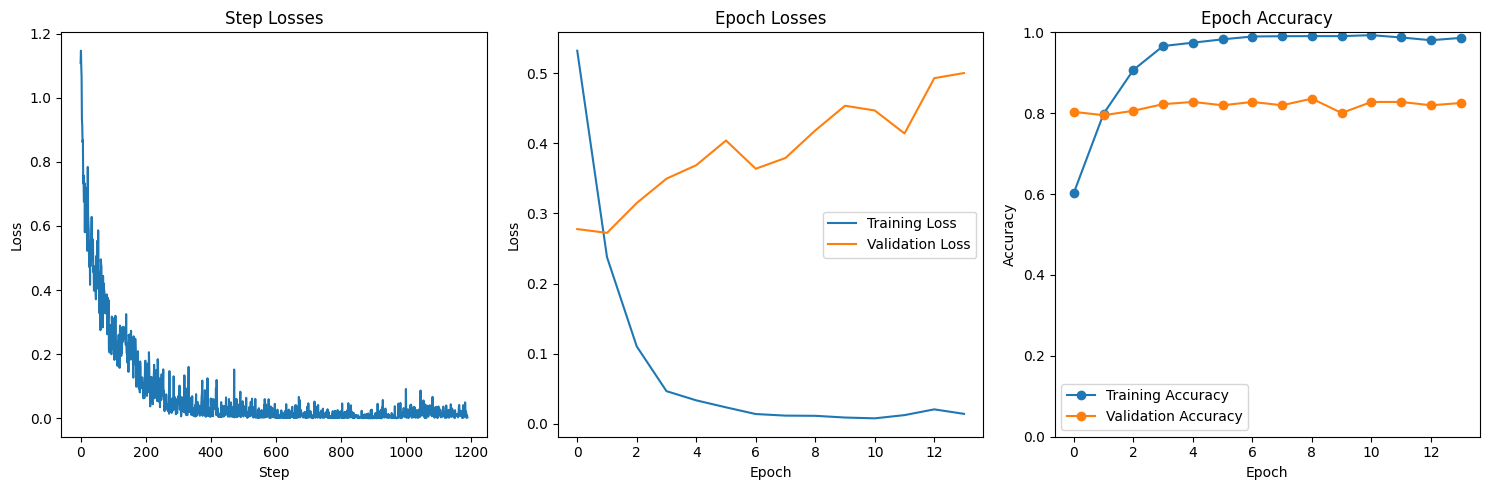

(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: title={'center': 'Step Losses'}, xlabel='Step', ylabel='Loss'>,
        <Axes: title={'center': 'Epoch Losses'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Epoch Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

In [132]:
plot_history(history = history)

Partono 1 esperimenti...

[1/1] ResNet18_run_001_optimizer_name=adam_lr=0.001_criterion_name=crossentropy_scheduler_name=
Epoch 1/30


Epoch 1 training loss: 0.9147 train acc=0.6483, validation loss: 1.1838 validation acc=0.6503
Epoch 2/30


Epoch 2 training loss: 0.6591 train acc=0.7563, validation loss: 0.6005 validation acc=0.7650
Epoch 3/30


Epoch 3 training loss: 0.5381 train acc=0.8069, validation loss: 1.2302 validation acc=0.6940
Epoch 4/30


Epoch 4 training loss: 0.4334 train acc=0.8431, validation loss: 0.8429 validation acc=0.6940
Epoch 5/30


Epoch 5 training loss: 0.3441 train acc=0.8751, validation loss: 0.6873 validation acc=0.7842
Epoch 6/30


Epoch 6 training loss: 0.1491 train acc=0.9549, validation loss: 0.7156 validation acc=0.7951
Epoch 7/30


Epoch 7 training loss: 0.0479 train acc=0.9880, validation loss: 0.9341 validation acc=0.7623
Epoch 8/30


Epoch 8 training loss: 0.0480 train acc=0.9877, validation loss: 0.8927 validation acc=0.7732
Epoch 9/30


Epoch 9 training loss: 0.0271 train acc=0.9937, validation loss: 0.8740 validation acc=0.7650
Epoch 10/30


Epoch 10 training loss: 0.0192 train acc=0.9946, validation loss: 0.8671 validation acc=0.7787
Epoch 11/30


Epoch 11 training loss: 0.0176 train acc=0.9943, validation loss: 0.8730 validation acc=0.7760
Early stopping.
Test Accuracy: 79.78% | Precision: 0.610 | Recall: 0.583 | F1: 0.590

Tutte le run sono salvate in: /Users/ire/Documents/2° Year/SELECTED TOPICS /project/dataset//results/ResNet18.csv


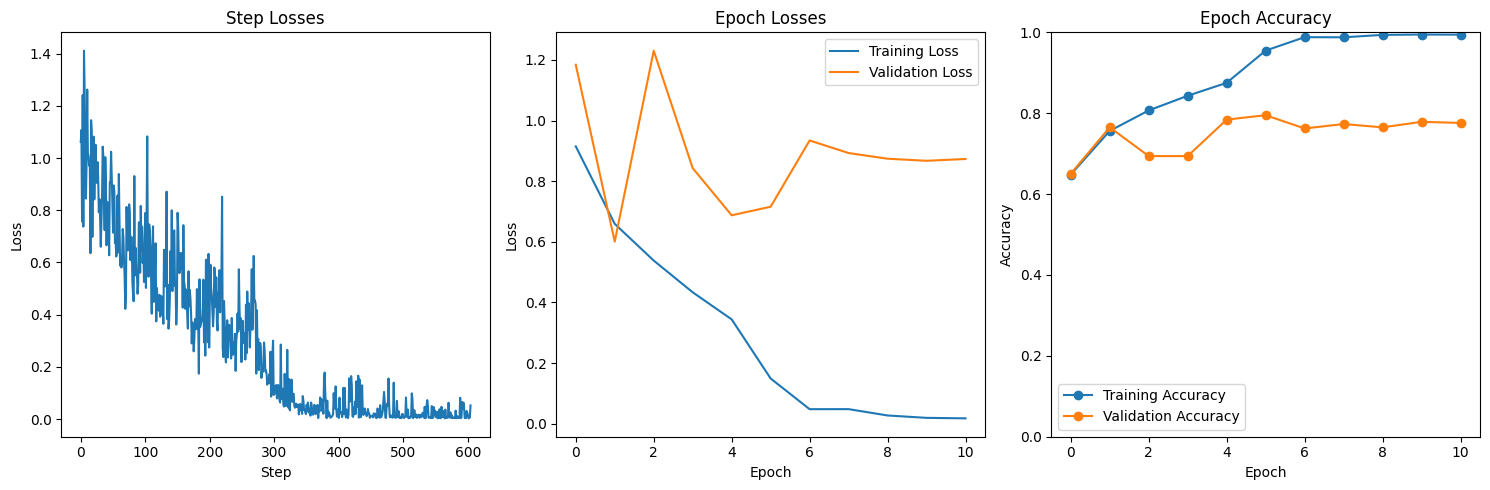

In [69]:
def model_fn():
    return model_resnet18

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="ResNet18",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device,
        model_output_softmax = False
    )


Confusion Matrix:
 [[195   3   1   0   0]
 [  3  13  13   0   1]
 [  2   4  74   6   1]
 [  0   0  10   6   1]
 [  0   2  12   4  15]]
Test Accuracy: 82.79% | Precision: 0.689 | Recall: 0.614 | F1: 0.636


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Predicted labels: [0 2 3 1 0 0 2 2 1 2 0 0 2 0 2 0 0 0 0 2 0 0 2 2 1 0 0 0 0 0 2 0 2 2 2 0 2
 2 0 3 0 0 1 2 0 2 2 2 2 0 4 0 3 3 2 0 2 0 0 0 0 2 0 4]
True labels: [0 2 4 0 0 0 3 2 1 1 0 0 2 0 2 0 0 0 0 4 0 0 2 2 2 0 0 0 0 0 2 0 2 2 2 0 4
 2 0 3 0 0 2 2 0 4 2 2 2 0 4 0 2 2 2 0 3 0 0 0 2 1 0 3]


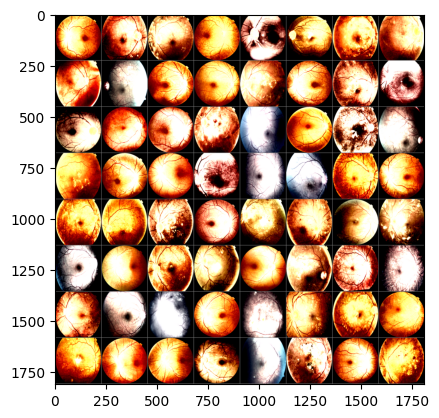

In [133]:
metrics, cm = evaluate_model(
    model_resnet18,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_resnet18(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model_resnet18")

# Simone's Model

In [ ]:
class Simone(nn.Module):                                                                                                                                                                                
    def __init__(self):
        super(Simone, self).__init__()
        # creating the layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, stride=1, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout(p=0.2)  # 20% di dropout
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=128*int(img_size/4)*int(img_size/4), out_features=128)
        self.dropout3 = nn.Dropout(p=0.5)  # 50% di dropout
        self.fc2 = nn.Linear(in_features=128, out_features=5)

    def forward(self, x):
        # Employing the layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, 128*int(img_size/4)*int(img_size/4))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout3(x)  # applico dropout solo durante il training
        x = self.fc2(x)

        return x

In [ ]:
model_simone = Simone()
print(model_simone)
summary(model_simone, input_size=(batch_size, 3, img_size, img_size))

In [ ]:
history, model_simone = train_model(
    model = model_simone,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer = "adam",
    lr=1e-3,
    num_epochs = 30,
    device = device,
    scheduler_name=""
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model_simone,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_simone(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model_simone")

In [ ]:
def model_fn():
    return Simone()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="Simone",
        csv_folder = base_path+"/results/",
        num_epochs=30,
        device=device
    )

# Simone2's Model

In [ ]:
class Simone2(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32,32,3,padding=1),   nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1),   nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64,128,3,padding=1),  nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.gap = nn.AdaptiveAvgPool2d(10)  # output: (B,128,1,1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128*28*28, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 5)
        )
    def forward(self, x):
        x = self.body(x)
        x = self.gap(x)
        x = self.head(x)
        return x

In [ ]:
model_simone2 = Simone2()
print(model_simone2)
summary(model_simone2, input_size=(batch_size, 3, img_size, img_size))

In [ ]:
history, model_simone2 = train_model(
    model = model_simone2,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion_name = "crossentropy",
    optimizer = "adam",
    num_epochs = 100,
    device = device,
    scheduler_name=""
)

In [ ]:
plot_history(history = history)

In [ ]:
metrics, cm = evaluate_model(
    model,
    test_loader,
    show_confusion=True
)

# Make predictions on a few sample images
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images.to(device) # Move sample_images to the same device as the model
sample_preds = model_simone2(sample_images)
sample_preds_labels = torch.argmax(sample_preds, dim=1).cpu().numpy() # Move predictions back to CPU for numpy conversion


print("Predicted labels:", sample_preds_labels)
print("True labels:", sample_labels.numpy())

imshow(torchvision.utils.make_grid(sample_images.cpu())) # Move images back to CPU for imshow

In [ ]:
cleanup_torch_env("model_rsg")

# Try automatic grid search

In [ ]:
def model_fn():
    return Simone2()

run_experiments_to_single_csv(
        model_fn=model_fn,
        train_loader=loader_selected,
        val_loader=val_loader,
        test_loader=test_loader,
        param_grid=grid,
        model_name="Simone2",
        csv_folder = base_path+"/results/",
        num_epochs=5,
        device=device
    )